In [0]:
# Setting-up the notebook and connecting with gdrive.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Mounting the google drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [1]:
cd drive/deeplearning/PRML_Project/

/content/drive/deeplearning/PRML_Project


In [0]:
import cv2
import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

from scipy.stats import spearmanr as SRCC
from scipy.io import savemat, loadmat

import random
from random import shuffle
from datetime import datetime

from data_utils import ImageDataGenerator, EncodingDataGenerator
from alexnet import AlexNet

np.random.seed(2018) # Setting up a numpy seed.
random.seed(2018)    # Setting up a python random lib seed.

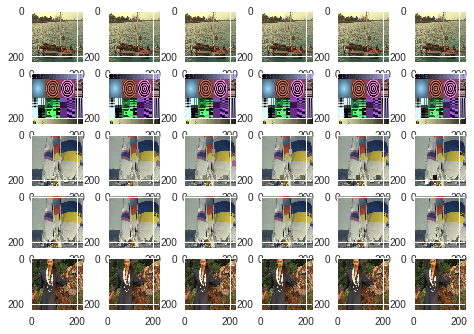

In [17]:
data_dir = "tid2013/"
g = ImageDataGenerator(data_dir)
imgs_batch, mos_batch = g.get_next_batch(batch_size = 32)

no_images = 5


for i in range(no_images):
  
  for d in range(6):
      plt.subplot(no_images, 6, 6 * i + d + 1)
      plt.imshow(np.flip((imgs_batch['level' + str(d)][i] + g.mean) / 255., axis = -1))

plt.show()

In [3]:
# Initalize the image encodings generator and obtaining the AlexNet encodings.
enc_utils = EncodingDataGenerator(encoding_dim = 4096,
                                  alexnet_batch_size = 30,
                                  saved_encodings = True
                                 )

No. of reference images used for training: 480
No. of reference images used for testing: 120


In [4]:
encs_batch, mos_batch = enc_utils.get_next_batch_test(20)
(encs_batch.shape, mos_batch.shape)

((100, 4096), (100, 1))

In [22]:
enc_utils.mos['level1'].T.shape

(600, 1)

In [0]:
################# ARCHITECTURE-1 #################

tf.reset_default_graph()

def ff_model(X, drop_prob, is_training):
  h = tf.layers.dense(
      name = 'ff1',
      inputs = X, 
      units = 1024, 
      activation = tf.nn.relu,
      kernel_initializer = tf.contrib.layers.xavier_initializer(),
      reuse = tf.AUTO_REUSE
  ) # Dense layer with 1024 units.
  h = tf.layers.dropout(
      name = 'dropout1',
      inputs = h,
      rate = drop_prob,
      training = is_training
  ) # Dropout layer.
  h = tf.layers.dense(
      name = 'ff2',
      inputs = h,
      units = 512,
      activation = tf.nn.relu,
      kernel_initializer = tf.contrib.layers.xavier_initializer(),
      reuse = tf.AUTO_REUSE
  ) # Dense layer with 512 units.
  h = tf.layers.dropout(
      name = 'dropout2',
      inputs = h,
      rate = drop_prob,
      training = is_training
  ) # Dropout layer
  h = tf.layers.dense(
      name = 'ff3',
      inputs = h,
      units = 1,
      activation = tf.nn.relu,
      kernel_initializer = tf.contrib.layers.xavier_initializer(),
      reuse = tf.AUTO_REUSE
  ) # Dense layer with 1 unit
  
  return h

In [0]:
################# ARCHITECTURE-2 #################

tf.reset_default_graph()

def ff_model(X, drop_prob, is_training):
  h = tf.layers.dense(
      name = 'ff1',
      inputs = X, 
      units = 1024, 
      activation = tf.nn.relu,
      kernel_initializer = tf.contrib.layers.xavier_initializer(),
      reuse = tf.AUTO_REUSE
  ) # Dense layer with 1024 units.
  h = tf.layers.dropout(
      name = 'dropout1',
      inputs = h,
      rate = drop_prob,
      training = is_training
  ) # Dropout layer.
  h = tf.layers.dense(
      name = 'ff2',
      inputs = h,
      units = 512,
      activation = tf.nn.sigmoid,
      kernel_initializer = tf.contrib.layers.xavier_initializer(),
      reuse = tf.AUTO_REUSE
  ) # Dense layer with 512 units.
  
  return h

In [0]:
# Learning params
learning_rate = 0.001
num_epochs = 50
batch_size = 120
encoding_dim = 4096

# Network params
dropout_rate = 0.5
latent_dim = 512
margin = 1.9

filewriter_path = "tmp/finetune_alexnet/summaries"
checkpoint_path = "tmp/finetune_alexnet/"
if not os.path.isdir(checkpoint_path): os.mkdir(checkpoint_path)

# How often we want to write the tf.summary data to disk
display_step = 1

X0 = tf.placeholder(tf.float32, [batch_size, encoding_dim], name = 'ref')
X1 = tf.placeholder(tf.float32, [batch_size, encoding_dim], name = 'l1')
X2 = tf.placeholder(tf.float32, [batch_size, encoding_dim], name = 'l2')
X3 = tf.placeholder(tf.float32, [batch_size, encoding_dim], name = 'l3')
is_training = tf.placeholder_with_default(True, shape = (), name = 'train_bool')

h0 = ff_model(X0, dropout_rate, is_training)
score0 = tf.squeeze(h0) # Scale between 0 and 10
#score0 = tf.norm(h0, axis = -1) * (10. / latent_dim)

h1 = ff_model(X1, dropout_rate, is_training)
score1 = tf.squeeze(h1) # Scale between 0 and 10
#score1 = tf.norm(h1, axis = -1) * (10./ latent_dim)

h2 = ff_model(X2, dropout_rate, is_training)
score2 = tf.squeeze(h2) # Scale between 0 and 10
#score2 = tf.norm(h2, axis = -1) * (10. / latent_dim)

h3 = ff_model(X3, dropout_rate, is_training)
score3 = tf.squeeze(h3) # Scale between 0 and 10
#score3 = tf.norm(h3, axis = -1) * (10. / latent_dim)

with tf.name_scope("margin_loss"):
    loss = tf.reduce_mean(
        tf.abs(10. - score0) + \
        tf.maximum(0., score1 + margin - score0) + \
        tf.maximum(0., score2 + 2 * margin - score0) + \
        tf.maximum(0., score3 + 3 * margin - score0), axis = 0
    )

In [6]:
# Train op
with tf.name_scope("train"):
  # Optimizer.
  optimizer = tf.train.AdamOptimizer()
  
  # Gradients.
  gradients = optimizer.compute_gradients(loss)
  
  # Update weights.
  train_step = optimizer.apply_gradients(gradients)

  # Add gradients to summary
  for gradient, var in gradients:
      tf.summary.histogram(var.name + '/gradient', gradient)

# Add the loss to summary
tf.summary.scalar('margin_loss', loss)

# Merge all summaries together
merged_summary = tf.summary.merge_all()

# Initialize the FileWriter
writer = tf.summary.FileWriter(filewriter_path)

# Initialize an saver for store model checkpoints
saver = tf.train.Saver()
init = tf.global_variables_initializer()

INFO:tensorflow:Summary name ff1/kernel:0/gradient is illegal; using ff1/kernel_0/gradient instead.
INFO:tensorflow:Summary name ff1/bias:0/gradient is illegal; using ff1/bias_0/gradient instead.
INFO:tensorflow:Summary name ff2/kernel:0/gradient is illegal; using ff2/kernel_0/gradient instead.
INFO:tensorflow:Summary name ff2/bias:0/gradient is illegal; using ff2/bias_0/gradient instead.
INFO:tensorflow:Summary name ff3/kernel:0/gradient is illegal; using ff3/kernel_0/gradient instead.
INFO:tensorflow:Summary name ff3/bias:0/gradient is illegal; using ff3/bias_0/gradient instead.


In [7]:
no_iters_per_epoch_train = enc_utils.num_train // batch_size
no_iters_per_epoch_val   = enc_utils.num_train // batch_size
best_val_loss = np.infty

train_losses = []
val_losses = []
val_SRCC = []

with tf.Session() as sess:
    if tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run(session = sess)

    # Add the model graph to TensorBoard
    writer.add_graph(sess.graph)

    print("{} Start training...".format(datetime.now()))
    print("{} Open Tensorboard at --logdir {}".format(datetime.now(), 
                                                      filewriter_path))
    
    for epoch in range(num_epochs):
        print("{} Epoch number: {}".format(datetime.now(), epoch+1))
        
        enc_utils.shuffle_encs() # Shuffling the data for every epoch.
        
        total_train_loss = 0.        
        for iteration in range(1, 1 + no_iters_per_epoch_train):
            
            encs_batch, mos_batch = enc_utils.get_next_batch_train(
                data = 'train', 
                batch_size = batch_size
            )

            images_q0, images_q1, images_q2, images_q3 = \
            encs_batch['q0'], encs_batch['q1'], encs_batch['q2'], encs_batch['q3']
            
            _, train_loss = sess.run([train_step, loss],
                                     feed_dict = {
                                         X0: images_q0,
                                         X1: images_q1,
                                         X2: images_q2,
                                         X3: images_q3,
                                         is_training: True
                                     }
                                    )
            print ("\rIteration: {}/{} ({:.1f}%) Loss: {:.5f}".format(
                iteration, no_iters_per_epoch_train,
                iteration * 100 / no_iters_per_epoch_train,
                train_loss),
                   end = "")
            if iteration % display_step == 0:
                s = sess.run(merged_summary, 
                             feed_dict={
                                 X0: images_q0,
                                 X1: images_q1,
                                 X2: images_q2,
                                 X3: images_q3,
                                 is_training: False})
                
                writer.add_summary(s, epoch * no_iters_per_epoch_train + iteration)
                
            total_train_loss += train_loss
                
        print("{} Start validation".format(datetime.now()))
        
        total_val_loss = 0.
        total_val_srcc = 0.
        pred_scores = []
        for iteration in range(1, 1 + no_iters_per_epoch_val):

            encs_batch, mos_batch = enc_utils.get_next_batch_train(
                data = 'val', 
                batch_size = batch_size
            )
            
            images_q0, images_q1, images_q2, images_q3 = \
            encs_batch['q0'], encs_batch['q1'], encs_batch['q2'], encs_batch['q3']
            
            true_mos0, true_mos1, true_mos2, true_mos3 = \
            mos_batch['q0'], mos_batch['q1'], mos_batch['q2'], mos_batch['q3']

            _, val_loss, pred_mos0, pred_mos1, pred_mos2, pred_mos3 = \
            sess.run(
                [train_step, loss, score0, score1, score2, score3],
                feed_dict = {X0: images_q0,
                             X1: images_q1,
                             X2: images_q2,
                             X3: images_q3,
                             is_training: False
                            }
            )
            val_srcc = SRCC(
                np.concatenate([pred_mos0, pred_mos1, pred_mos2, pred_mos3]),
                np.concatenate([true_mos0, true_mos1, true_mos2, true_mos3])
            )[0]
            total_val_loss += val_loss
            total_val_srcc += val_srcc

        print ("Validation loss: {:.4f} ".format(
            val_loss / no_iters_per_epoch_val),
              end = "")
        print ("Validation SRCC: {:.4f} ".format(
            total_val_srcc / no_iters_per_epoch_val),
              end = "")

        if val_loss < best_val_loss:
            print("{} Saving checkpoint of model...".format(datetime.now()))            
            
            save_path = saver.save(sess, checkpoint_path)
            best_val_loss = val_loss
            
        # Saving the losses and SRCC
        train_losses.append(total_train_loss / no_iters_per_epoch_train)
        val_losses.append(total_val_loss / no_iters_per_epoch_val)
        val_SRCC.append(total_val_srcc / no_iters_per_epoch_val)

sess.close()

2018-04-02 18:59:50.755252 Start training...
2018-04-02 18:59:50.757823 Open Tensorboard at --logdir tmp/finetune_alexnet/summaries
2018-04-02 18:59:50.757879 Epoch number: 1
Iteration: 4/4 (100.0%) Loss: 19.899942018-04-02 18:59:52.215319 Start validation
Validation loss: 3.3143 Validation SRCC: 0.2521 2018-04-02 18:59:52.430359 Saving checkpoint of model...
2018-04-02 19:00:07.079101 Epoch number: 2
Iteration: 4/4 (100.0%) Loss: 16.873692018-04-02 19:00:08.143103 Start validation
Validation loss: 2.7145 Validation SRCC: 0.4347 2018-04-02 19:00:08.228136 Saving checkpoint of model...
2018-04-02 19:00:28.923002 Epoch number: 3
Iteration: 4/4 (100.0%) Loss: 14.617612018-04-02 19:00:30.254993 Start validation
Validation loss: 1.4146 Validation SRCC: 0.6940 2018-04-02 19:00:30.339055 Saving checkpoint of model...
2018-04-02 19:00:52.784248 Epoch number: 4
Iteration: 4/4 (100.0%) Loss: 13.463482018-04-02 19:00:53.759009 Start validation
Validation loss: 1.1838 Validation SRCC: 0.7426 2018-

Iteration: 4/4 (100.0%) Loss: 7.572202018-04-02 19:03:17.733028 Start validation
Validation loss: 0.6459 Validation SRCC: 0.8483 2018-04-02 19:03:17.823411 Saving checkpoint of model...
2018-04-02 19:03:41.264814 Epoch number: 15
Iteration: 4/4 (100.0%) Loss: 7.543042018-04-02 19:03:42.092330 Start validation
Validation loss: 0.6115 Validation SRCC: 0.8524 2018-04-02 19:03:42.173881 Saving checkpoint of model...
2018-04-02 19:04:10.746045 Epoch number: 16
Iteration: 4/4 (100.0%) Loss: 9.318332018-04-02 19:04:11.556880 Start validation
Validation loss: 0.6373 Validation SRCC: 0.8595 2018-04-02 19:04:11.637787 Epoch number: 17
Iteration: 4/4 (100.0%) Loss: 8.300452018-04-02 19:04:12.449047 Start validation
Validation loss: 0.5573 Validation SRCC: 0.8477 2018-04-02 19:04:12.534619 Saving checkpoint of model...
2018-04-02 19:04:36.021765 Epoch number: 18
Iteration: 4/4 (100.0%) Loss: 8.988952018-04-02 19:04:36.832679 Start validation
Validation loss: 0.6810 Validation SRCC: 0.8496 2018-04-

Iteration: 4/4 (100.0%) Loss: 7.260362018-04-02 19:05:52.016923 Start validation
Validation loss: 0.5680 Validation SRCC: 0.8608 2018-04-02 19:05:52.108182 Epoch number: 32
Iteration: 4/4 (100.0%) Loss: 7.302502018-04-02 19:05:52.872486 Start validation
Validation loss: 0.4421 Validation SRCC: 0.8735 2018-04-02 19:05:52.956570 Saving checkpoint of model...
2018-04-02 19:06:12.936415 Epoch number: 33
Iteration: 4/4 (100.0%) Loss: 6.208272018-04-02 19:06:13.661311 Start validation
Validation loss: 0.4649 Validation SRCC: 0.8709 2018-04-02 19:06:13.741969 Epoch number: 34
Iteration: 4/4 (100.0%) Loss: 6.506712018-04-02 19:06:14.473967 Start validation
Validation loss: 0.4604 Validation SRCC: 0.8762 2018-04-02 19:06:14.554362 Epoch number: 35
Iteration: 4/4 (100.0%) Loss: 5.867682018-04-02 19:06:15.251594 Start validation
Validation loss: 0.4583 Validation SRCC: 0.8703 2018-04-02 19:06:15.332499 Epoch number: 36
Iteration: 4/4 (100.0%) Loss: 6.069702018-04-02 19:06:16.055456 Start validati

Iteration: 4/4 (100.0%) Loss: 5.103122018-04-02 19:07:07.813720 Start validation
Validation loss: 0.3494 Validation SRCC: 0.8848 2018-04-02 19:07:07.900303 Saving checkpoint of model...
2018-04-02 19:07:28.363092 Epoch number: 50
Iteration: 4/4 (100.0%) Loss: 6.414052018-04-02 19:07:29.024442 Start validation
Validation loss: 0.4118 Validation SRCC: 0.8779 

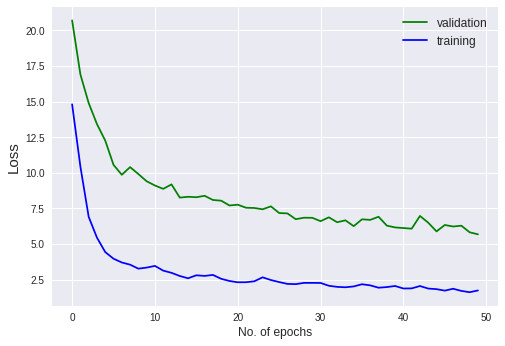

In [16]:
### PLOTS ###

plt.plot(range(num_epochs), train_losses, 'g', range(num_epochs), val_losses, 'b')
plt.legend(['validation', 'training'], fontsize = 12)
plt.xlabel('No. of epochs', fontsize = 12)
plt.ylabel('Loss', fontsize = 15)
plt.savefig('plots/train_val_loss.png', dpi = 300, format = 'png')
plt.show()

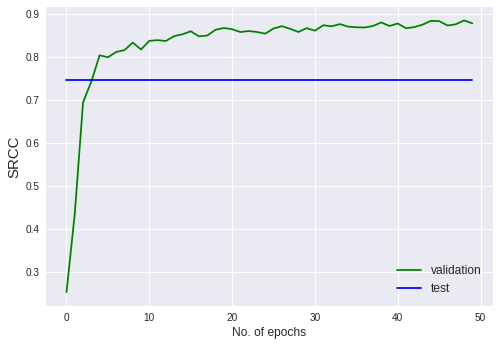

In [18]:
### PLOTS ###

plt.plot(range(num_epochs), val_SRCC, 'g', range(num_epochs), [test_SRCC] * num_epochs, 'b')
plt.legend(['validation', 'test'], fontsize = 12)
plt.xlabel('No. of epochs', fontsize = 12)
plt.ylabel('SRCC', fontsize = 15)
plt.savefig('plots/val_test_SRCC.png', dpi = 300, format = 'png')
plt.show()

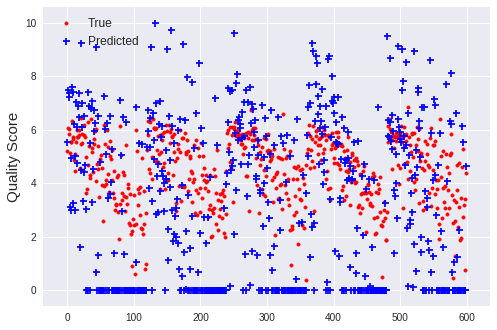

In [15]:
plt.scatter(range(600), true_mos_test, c = 'r', marker = '.')
plt.scatter(range(600), preds_mos_test / max(preds_mos_test) * 10., c = 'b', marker = '+')
plt.legend(['True', 'Predicted'], fontsize = 12)
plt.ylabel('Quality Score', fontsize = 15)
plt.savefig('plots/scatter_true_pred.png', dpi = 300, format = 'png')
plt.show()

In [47]:
SRCC(true_mos_test, preds_mos_test)[0]

0.7591584393373966

In [20]:
from scipy.stats import pearsonr as LCC

LCC(true_mos_test, preds_mos_test)[0]

0.7054772185566677

In [10]:
################# Evaluating the model on Test set ################
no_iters_per_epoch_test = enc_utils.num_test // (batch_size // 5)

with tf.Session() as sess:
  if tf.train.checkpoint_exists(checkpoint_path):
    saver.restore(sess, checkpoint_path)
  else:
    init.run(session = sess)
    
  preds_mos_test = np.ndarray([enc_utils.num_test * 5, ])
  true_mos_test = np.ndarray([enc_utils.num_test * 5, ])
  encs = np.ndarray([enc_utils.num_test * 5, latent_dim])
  
  for iteration in range(1, 1 + no_iters_per_epoch_test):
    
    encs_batch, mos_batch = enc_utils.get_next_batch_test(batch_size // 5)
    
    pred_mos, h = sess.run([score0, h0],
                           feed_dict = {
                               X0: encs_batch,
                               X1: np.zeros([batch_size, encoding_dim]),
                               X2: np.zeros([batch_size, encoding_dim]),
                               X3: np.zeros([batch_size, encoding_dim]),
                               is_training: False
                           }
                       )   
    first = enc_utils.first
    last = enc_utils.last
    
    preds_mos_test[5 * first : 5 * last] = pred_mos
    true_mos_test[5 * first : 5 * last] = mos_batch[:, 0]
    encs[5 * first : 5 * last] = h
        
    print (5 * first, 5 * last)
sess.close()

test_SRCC = SRCC(preds_mos_test, true_mos_test)[0]
print ("Test SRCC: %.2f" % (test_SRCC))

INFO:tensorflow:Restoring parameters from tmp/finetune_alexnet/
0 120
120 240
240 360
360 480
480 600
Test SRCC: 0.75


In [0]:
from sklearn.manifold import TSNE

tsne_embs = TSNE(n_components = 2).fit_transform(encs)

In [19]:
tsne_embs.shape

(600, 2)

In [0]:
embs = {
    '1': [],
    '2': [],
    '3': [],
    '4': [],
    '5': []
}

for i in range(1, 5):
  for d in range(5):
    start = batch_size * d + (batch_size // 5) * (i - 1)
    end = start + (batch_size // 5) * i
    
    embs[str(i)].append(tsne_embs[start : end])
  
  embs[str(i)] = np.concatenate(embs[str(i)], axis = 0)

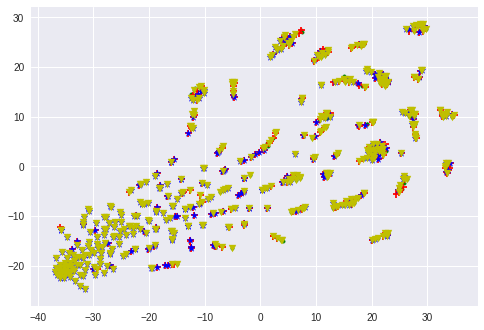

In [55]:
plt.scatter(embs['1'][:, 0], embs['1'][:, 1], c = 'g', marker = '.')
plt.scatter(embs['2'][:, 0], embs['2'][:, 1], c = 'r', marker = '+')
plt.scatter(embs['3'][:, 0], embs['3'][:, 1], c = 'b', marker = '*')
plt.scatter(embs['4'][:, 0], embs['4'][:, 1], c = 'y', marker = 'v')

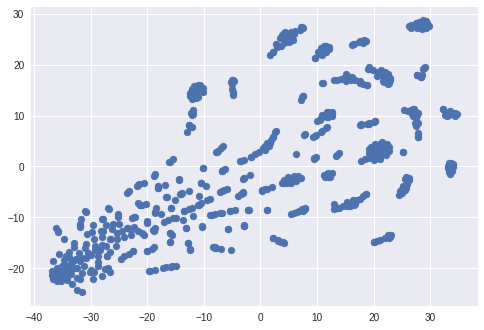

In [57]:
plt.scatter(tsne_embs[:, 0], tsne_embs[:, 1])

In [120]:
import os
import tboard

# set paths
ROOT = %pwd
LOG_DIR = os.path.join(ROOT, 'finetune_alexnet_summaries')

# will install `ngrok`, if necessary
# will create `log_dir` if path does not exist
tboard.launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )

ngrok installed
status: tensorboard=True, ngrok=True
tensorboard url= http://c359e4fb.ngrok.io


'http://c359e4fb.ngrok.io'

In [0]:
cp content/drive/deeplearning/PRML_Project/tmp/finetune_alexnet/summaries/events.out.tfevents.1522685975.88534fbbb7f7 /tmp/tmp/finetune_alexnet/summaries/

In [119]:
ls /tmp/tmp/finetune_alexnet/summaries/

events.out.tfevents.1522685975.88534fbbb7f7
